In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow.keras as keras
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
data = pd.read_csv("./soil_data.csv")
data

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1005,31.870670,-85.405456,146,0.0158,0.1868,0.5441,0.2424,0.0106,0.0003,...,72.578804,1.828159,74.406960,3,2,1,1,1,1,1
2,1003,30.659218,-87.746067,52,0.0746,0.4370,0.4415,0.0469,0.0000,0.0000,...,59.843639,2.996914,62.840553,3,2,1,2,1,1,1
3,1007,33.015893,-87.127148,93,0.0144,0.1617,0.3714,0.3493,0.0898,0.0134,...,1.916593,0.008330,1.924924,3,2,1,1,1,1,1
4,1009,33.977448,-86.567246,198,0.0050,0.0872,0.2799,0.3576,0.1477,0.1037,...,1.891909,0.027488,1.919397,3,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,56037,41.660339,-108.875676,2085,0.0016,0.0281,0.1763,0.3554,0.2121,0.2097,...,0.000000,0.000000,0.000000,1,1,3,1,1,1,3
3105,56039,44.049321,-110.588102,2564,0.0003,0.0026,0.0166,0.0722,0.1489,0.5005,...,2.922309,0.000000,2.922309,1,1,1,1,1,1,1
3106,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
3107,56041,41.284726,-110.558947,2327,0.0050,0.2009,0.4063,0.1858,0.0964,0.1031,...,1.013702,10.755590,11.769293,1,1,2,1,1,1,2


In [4]:
train_data = pd.read_csv("./train_timeseries.csv")
train_data

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19300675,56043,2016-12-27,0.16,82.88,1.63,-7.97,-13.49,-12.81,-1.39,-13.60,...,-9.41,5.90,7.63,3.61,4.02,8.58,10.39,5.92,4.47,0.0
19300676,56043,2016-12-28,0.02,83.33,1.41,-8.71,-14.10,-13.84,-2.49,-13.56,...,-10.55,6.50,11.43,4.11,7.32,9.92,14.49,7.26,7.22,NaN
19300677,56043,2016-12-29,0.00,83.75,1.59,-7.96,-13.30,-13.03,0.42,-14.51,...,-10.29,4.29,6.24,2.03,4.22,6.56,10.07,3.20,6.87,NaN
19300678,56043,2016-12-30,1.22,82.49,2.63,-2.94,-7.40,-7.33,3.76,-6.86,...,-4.14,4.98,7.34,1.99,5.35,7.28,10.12,3.24,6.89,NaN


In [5]:
train_data = train_data[train_data['date'] <= '2013-12-31']

In [6]:
result = pd.merge(train_data, data, on='fips', how='inner')

In [7]:
result

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15894307,56043,2013-12-27,0.06,83.42,3.04,-1.22,-5.47,-5.43,5.90,-5.29,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15894308,56043,2013-12-28,0.72,83.17,2.17,-5.22,-9.73,-9.61,-0.86,-12.02,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15894309,56043,2013-12-29,0.20,83.17,1.69,-8.08,-12.21,-12.08,-1.21,-13.51,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15894310,56043,2013-12-30,0.04,83.18,2.30,-3.98,-8.74,-8.66,2.40,-8.74,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [8]:
result =  result.drop(['score'], axis=1)

In [9]:
train = result[(result['date'] >= '2000-01-01') & (result['date'] <= '2008-12-31')]
validation = result[(result['date'] >= '2009-01-01') & (result['date'] <= '2010-12-31')]
test = result[(result['date'] >= '2011-01-01') & (result['date'] <= '2012-12-31')]

In [10]:
train

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15892481,56043,2008-12-27,0.70,82.31,1.47,-10.39,-14.50,-14.23,-2.84,-16.79,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15892482,56043,2008-12-28,0.28,82.80,2.66,-4.52,-7.41,-7.37,2.14,-9.60,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15892483,56043,2008-12-29,0.36,82.77,3.35,-1.00,-4.38,-4.36,4.18,-5.80,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15892484,56043,2008-12-30,1.08,83.28,1.71,-4.75,-12.42,-12.11,2.01,-10.46,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [11]:
validation

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
3288,1001,2009-01-01,0.01,100.69,3.66,3.63,-0.75,-0.72,11.42,-3.64,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3289,1001,2009-01-02,2.71,100.15,7.29,9.71,8.96,8.96,13.03,5.97,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3290,1001,2009-01-03,9.09,100.12,10.66,15.36,14.91,14.91,19.45,11.91,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3291,1001,2009-01-04,6.31,100.37,10.56,15.55,14.88,14.88,19.34,13.36,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3292,1001,2009-01-05,18.56,100.17,11.01,16.24,15.44,15.44,19.49,12.75,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15893211,56043,2010-12-27,0.00,83.02,1.95,-4.33,-10.64,-10.47,2.10,-8.03,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15893212,56043,2010-12-28,0.03,82.35,2.08,-5.43,-10.13,-10.01,1.07,-10.15,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15893213,56043,2010-12-29,1.26,80.57,2.93,-1.48,-6.29,-6.24,3.36,-5.36,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15893214,56043,2010-12-30,3.67,81.43,1.15,-12.76,-16.88,-16.48,-6.34,-17.29,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [12]:
test 

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
4018,1001,2011-01-01,40.22,100.10,8.99,13.17,12.08,12.08,17.51,7.61,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4019,1001,2011-01-02,0.02,100.85,3.34,3.48,-2.08,-2.01,8.69,-3.74,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4020,1001,2011-01-03,0.00,100.93,2.60,2.19,-5.02,-4.91,10.40,-6.08,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4021,1001,2011-01-04,0.05,100.53,3.67,6.28,-0.59,-0.55,13.98,0.18,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4022,1001,2011-01-05,4.24,99.86,5.88,6.97,5.78,5.79,10.42,2.27,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15893942,56043,2012-12-27,1.33,82.23,1.76,-8.43,-11.79,-11.67,-4.52,-10.35,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15893943,56043,2012-12-28,0.08,82.80,1.53,-8.00,-13.29,-13.07,-1.95,-11.53,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15893944,56043,2012-12-29,0.01,82.92,1.29,-10.03,-15.05,-14.77,-3.07,-15.59,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15893945,56043,2012-12-30,0.02,82.83,1.37,-9.48,-14.42,-14.16,-2.66,-13.37,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [13]:
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test = test.reset_index(drop=True)

In [14]:
train['date'] = pd.to_datetime(train['date'])


train['Year'] = train['date'].dt.year
train['Month'] = train['date'].dt.month
train['Day'] = train['date'].dt.day

train = train.drop(columns=['date'])
train

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,Year,Month,Day
0,1001,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,9.50,...,1,1,1,1,1,1,2,2000,1,1
1,1001,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,10.18,...,1,1,1,1,1,1,2,2000,1,2
2,1001,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,7.41,...,1,1,1,1,1,1,2,2000,1,3
3,1001,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,...,1,1,1,1,1,1,2,2000,1,4
4,1001,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,13.48,...,1,1,1,1,1,1,2,2000,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10219099,56043,0.70,82.31,1.47,-10.39,-14.50,-14.23,-2.84,-16.79,13.95,...,1,1,1,1,1,1,1,2008,12,27
10219100,56043,0.28,82.80,2.66,-4.52,-7.41,-7.37,2.14,-9.60,11.74,...,1,1,1,1,1,1,1,2008,12,28
10219101,56043,0.36,82.77,3.35,-1.00,-4.38,-4.36,4.18,-5.80,9.98,...,1,1,1,1,1,1,1,2008,12,29
10219102,56043,1.08,83.28,1.71,-4.75,-12.42,-12.11,2.01,-10.46,12.46,...,1,1,1,1,1,1,1,2008,12,30


In [15]:
validation['date'] = pd.to_datetime(validation['date'])

validation['Year'] = validation['date'].dt.year
validation['Month'] = validation['date'].dt.month
validation['Day'] = validation['date'].dt.day

validation = validation.drop(columns=['date'])
validation

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,Year,Month,Day
0,1001,0.01,100.69,3.66,3.63,-0.75,-0.72,11.42,-3.64,15.06,...,1,1,1,1,1,1,2,2009,1,1
1,1001,2.71,100.15,7.29,9.71,8.96,8.96,13.03,5.97,7.06,...,1,1,1,1,1,1,2,2009,1,2
2,1001,9.09,100.12,10.66,15.36,14.91,14.91,19.45,11.91,7.54,...,1,1,1,1,1,1,2,2009,1,3
3,1001,6.31,100.37,10.56,15.55,14.88,14.88,19.34,13.36,5.98,...,1,1,1,1,1,1,2,2009,1,4
4,1001,18.56,100.17,11.01,16.24,15.44,15.44,19.49,12.75,6.74,...,1,1,1,1,1,1,2,2009,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268835,56043,0.00,83.02,1.95,-4.33,-10.64,-10.47,2.10,-8.03,10.12,...,1,1,1,1,1,1,1,2010,12,27
2268836,56043,0.03,82.35,2.08,-5.43,-10.13,-10.01,1.07,-10.15,11.22,...,1,1,1,1,1,1,1,2010,12,28
2268837,56043,1.26,80.57,2.93,-1.48,-6.29,-6.24,3.36,-5.36,8.72,...,1,1,1,1,1,1,1,2010,12,29
2268838,56043,3.67,81.43,1.15,-12.76,-16.88,-16.48,-6.34,-17.29,10.94,...,1,1,1,1,1,1,1,2010,12,30


In [16]:
test['date'] = pd.to_datetime(test['date'])


test['Year'] = test['date'].dt.year
test['Month'] = test['date'].dt.month
test['Day'] = test['date'].dt.day

test = test.drop(columns=['date'])
test

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,Year,Month,Day
0,1001,40.22,100.10,8.99,13.17,12.08,12.08,17.51,7.61,9.90,...,1,1,1,1,1,1,2,2011,1,1
1,1001,0.02,100.85,3.34,3.48,-2.08,-2.01,8.69,-3.74,12.43,...,1,1,1,1,1,1,2,2011,1,2
2,1001,0.00,100.93,2.60,2.19,-5.02,-4.91,10.40,-6.08,16.48,...,1,1,1,1,1,1,2,2011,1,3
3,1001,0.05,100.53,3.67,6.28,-0.59,-0.55,13.98,0.18,13.80,...,1,1,1,1,1,1,2,2011,1,4
4,1001,4.24,99.86,5.88,6.97,5.78,5.79,10.42,2.27,8.15,...,1,1,1,1,1,1,2,2011,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271943,56043,1.33,82.23,1.76,-8.43,-11.79,-11.67,-4.52,-10.35,5.83,...,1,1,1,1,1,1,1,2012,12,27
2271944,56043,0.08,82.80,1.53,-8.00,-13.29,-13.07,-1.95,-11.53,9.58,...,1,1,1,1,1,1,1,2012,12,28
2271945,56043,0.01,82.92,1.29,-10.03,-15.05,-14.77,-3.07,-15.59,12.52,...,1,1,1,1,1,1,1,2012,12,29
2271946,56043,0.02,82.83,1.37,-9.48,-14.42,-14.16,-2.66,-13.37,10.71,...,1,1,1,1,1,1,1,2012,12,30


In [17]:
print(train.columns)

Index(['fips', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
       'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'lat',
       'lon', 'elevation', 'slope1', 'slope2', 'slope3', 'slope4', 'slope5',
       'slope6', 'slope7', 'slope8', 'aspectN', 'aspectE', 'aspectS',
       'aspectW', 'aspectUnknown', 'WAT_LAND', 'NVG_LAND', 'URB_LAND',
       'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND', 'CULT_LAND',
       'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'Year', 'Month',
       'Day'],
      dtype='object')


In [18]:
dynamic_columns = ['Year', 'Month', 'Day', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS', 'WS10M', 'WS10M_MAX','WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE']  #dynamic features

In [19]:
dynamic_columns

['Year',
 'Month',
 'Day',
 'PS',
 'QV2M',
 'T2M',
 'T2MDEW',
 'T2MWET',
 'T2M_MAX',
 'T2M_MIN',
 'T2M_RANGE',
 'TS',
 'WS10M',
 'WS10M_MAX',
 'WS10M_MIN',
 'WS10M_RANGE',
 'WS50M',
 'WS50M_MAX',
 'WS50M_MIN',
 'WS50M_RANGE']

In [20]:
y_train = train['PRECTOT']
y_train

0            0.22
1            0.20
2            3.65
3           15.95
4            0.00
            ...  
10219099     0.70
10219100     0.28
10219101     0.36
10219102     1.08
10219103     0.54
Name: PRECTOT, Length: 10219104, dtype: float64

In [21]:
y_valid = validation['PRECTOT'] 
y_valid

0           0.01
1           2.71
2           9.09
3           6.31
4          18.56
           ...  
2268835     0.00
2268836     0.03
2268837     1.26
2268838     3.67
2268839     0.77
Name: PRECTOT, Length: 2268840, dtype: float64

In [22]:
y_test = test['PRECTOT']
y_test

0          40.22
1           0.02
2           0.00
3           0.05
4           4.24
           ...  
2271943     1.33
2271944     0.08
2271945     0.01
2271946     0.02
2271947     0.01
Name: PRECTOT, Length: 2271948, dtype: float64

In [23]:
train = train.drop(columns=['PRECTOT'])
validation = validation.drop(columns=['PRECTOT'])
test = test.drop(columns=['PRECTOT'])

In [24]:
dynamic_train = train[dynamic_columns] 
dynamic_train

,Year,Month,Day,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,2000,1,1,100.51,9.65,14.74,13.51,13.51,20.96,11.46,9.50,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81
1,2000,1,2,100.55,10.42,16.69,14.71,14.71,22.80,12.61,10.18,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41
2,2000,1,3,100.15,11.76,18.49,16.52,16.52,22.73,15.32,7.41,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66
3,2000,1,4,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58
4,2000,1,5,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,13.48,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10219099,2008,12,27,82.31,1.47,-10.39,-14.50,-14.23,-2.84,-16.79,13.95,-12.92,4.23,5.29,2.87,2.43,6.19,7.66,4.25,3.41
10219100,2008,12,28,82.80,2.66,-4.52,-7.41,-7.37,2.14,-9.60,11.74,-6.26,5.65,7.75,4.19,3.55,8.59,9.63,7.34,2.30
10219101,2008,12,29,82.77,3.35,-1.00,-4.38,-4.36,4.18,-5.80,9.98,-2.90,7.62,12.24,4.11,8.13,11.32,17.66,6.97,10.69
10219102,2008,12,30,83.28,1.71,-4.75,-12.42,-12.11,2.01,-10.46,12.46,-6.65,6.06,12.57,2.33,10.24,8.87,17.68,3.82,13.86


In [25]:
dynamic_valid = validation[dynamic_columns] #seperate dynamic features
dynamic_valid

,Year,Month,Day,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,2009,1,1,100.69,3.66,3.63,-0.75,-0.72,11.42,-3.64,15.06,3.69,2.57,3.82,1.82,2.00,5.10,6.62,4.17,2.45
1,2009,1,2,100.15,7.29,9.71,8.96,8.96,13.03,5.97,7.06,9.31,1.51,2.53,0.24,2.29,2.85,5.03,0.38,4.65
2,2009,1,3,100.12,10.66,15.36,14.91,14.91,19.45,11.91,7.54,15.24,2.17,2.83,1.82,1.01,4.82,5.91,3.50,2.41
3,2009,1,4,100.37,10.56,15.55,14.88,14.88,19.34,13.36,5.98,15.39,1.70,1.96,1.12,0.85,3.63,4.77,2.03,2.74
4,2009,1,5,100.17,11.01,16.24,15.44,15.44,19.49,12.75,6.74,16.11,1.98,4.01,0.54,3.47,4.06,7.64,1.10,6.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268835,2010,12,27,83.02,1.95,-4.33,-10.64,-10.47,2.10,-8.03,10.12,-6.26,4.08,6.90,2.39,4.51,6.39,8.52,3.75,4.77
2268836,2010,12,28,82.35,2.08,-5.43,-10.13,-10.01,1.07,-10.15,11.22,-6.70,4.55,6.31,2.68,3.63,6.89,9.48,4.39,5.09
2268837,2010,12,29,80.57,2.93,-1.48,-6.29,-6.24,3.36,-5.36,8.72,-2.66,5.22,8.11,1.26,6.85,7.25,11.04,2.30,8.74
2268838,2010,12,30,81.43,1.15,-12.76,-16.88,-16.48,-6.34,-17.29,10.94,-11.67,4.79,5.88,3.68,2.20,5.70,6.95,4.13,2.81


In [26]:
dynamic_test = test[dynamic_columns] #seperate dynamic features
dynamic_test

,Year,Month,Day,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,2011,1,1,100.10,8.99,13.17,12.08,12.08,17.51,7.61,9.90,13.04,3.44,4.77,1.99,2.78,6.22,8.63,3.25,5.38
1,2011,1,2,100.85,3.34,3.48,-2.08,-2.01,8.69,-3.74,12.43,3.45,2.93,4.45,1.90,2.55,5.47,6.77,4.59,2.18
2,2011,1,3,100.93,2.60,2.19,-5.02,-4.91,10.40,-6.08,16.48,0.54,1.23,2.28,0.19,2.09,2.32,4.72,0.23,4.49
3,2011,1,4,100.53,3.67,6.28,-0.59,-0.55,13.98,0.18,13.80,4.16,1.64,2.30,0.72,1.58,2.51,3.74,1.22,2.52
4,2011,1,5,99.86,5.88,6.97,5.78,5.79,10.42,2.27,8.15,6.39,1.82,2.84,0.13,2.70,3.49,5.89,0.21,5.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271943,2012,12,27,82.23,1.76,-8.43,-11.79,-11.67,-4.52,-10.35,5.83,-9.06,3.48,4.97,1.72,3.25,4.51,5.77,2.93,2.84
2271944,2012,12,28,82.80,1.53,-8.00,-13.29,-13.07,-1.95,-11.53,9.58,-10.04,2.96,5.31,1.86,3.45,4.41,6.46,2.97,3.49
2271945,2012,12,29,82.92,1.29,-10.03,-15.05,-14.77,-3.07,-15.59,12.52,-11.64,2.99,4.06,1.63,2.43,4.43,5.41,2.67,2.74
2271946,2012,12,30,82.83,1.37,-9.48,-14.42,-14.16,-2.66,-13.37,10.71,-10.99,1.75,2.86,0.80,2.06,2.52,4.82,0.83,3.99


In [27]:
static_train = train.drop(columns=dynamic_columns) #seperate static features
static_train

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10219099,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
10219100,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
10219101,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
10219102,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [28]:
static_valid = validation.drop(columns=dynamic_columns) #seperate static features
static_valid

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268835,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2268836,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2268837,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2268838,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [29]:
static_test = test.drop(columns=dynamic_columns)
static_test

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271943,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2271944,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2271945,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2271946,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [30]:
# Define the dimensions of the autoencoder
dynamic_input_dim = dynamic_train.shape[1]
dynamic_encoding_dim = 8

In [31]:
# Define the autoencoder model for dynamic features
dynamic_autoencoder = Sequential()
dynamic_autoencoder.add(Dense(dynamic_encoding_dim, activation='relu', input_shape=(dynamic_input_dim,)))
dynamic_autoencoder.add(Dense(dynamic_input_dim, activation='relu'))

In [55]:
# Compile and train the autoencoder for dynamic features
dynamic_autoencoder.compile(optimizer='adam', loss='mean_absolute_error')
dynamic_autoencoder.fit(dynamic_train, dynamic_train, epochs=10, batch_size=32)

Epoch 1/10
319347/319347 [==============================] - 574s 2ms/step - loss: 5.2353
Epoch 2/10
319347/319347 [==============================] - 552s 2ms/step - loss: 5.2352
Epoch 3/10
319347/319347 [==============================] - 541s 2ms/step - loss: 5.2346
Epoch 4/10
319347/319347 [==============================] - 536s 2ms/step - loss: 5.2338
Epoch 5/10
319347/319347 [==============================] - 538s 2ms/step - loss: 5.2340
Epoch 6/10
319347/319347 [==============================] - 534s 2ms/step - loss: 5.2335
Epoch 7/10
319347/319347 [==============================] - 531s 2ms/step - loss: 5.2330
Epoch 8/10
319347/319347 [==============================] - 529s 2ms/step - loss: 5.2333
Epoch 9/10
319347/319347 [==============================] - 528s 2ms/step - loss: 5.2329
Epoch 10/10
319347/319347 [==============================] - 521s 2ms/step - loss: 5.2324


In [33]:
from tensorflow.keras.models import Model, Sequential
encoder = Model(inputs=dynamic_autoencoder.input, outputs=dynamic_autoencoder.layers[0].output)

In [34]:
encoded_train = encoder.predict(dynamic_train)
encoded_validation = encoder.predict(dynamic_valid)
encoded_test = encoder.predict(dynamic_test)

70999/70999 [==============================] - 62s 869us/step


In [35]:
dynamic_train_df = pd.DataFrame(encoded_train)
dynamic_valid_df = pd.DataFrame(encoded_validation)
dynamic_test_df = pd.DataFrame(encoded_test)

In [36]:
dynamic_train_df

,0,1,2,3,4,5,6,7
0,10.099212,55.191895,0.0,0.0,1145.989380,27.220036,16.268921,136.984970
1,9.261881,50.872635,0.0,0.0,1146.113159,25.276041,19.201025,132.218781
2,7.785712,40.748676,0.0,0.0,1146.273438,24.521727,37.447014,126.898407
3,10.619493,89.098755,0.0,0.0,1145.654175,25.978878,31.993660,125.941597
4,12.055471,108.654259,0.0,0.0,1145.463501,34.947197,2.758100,123.675262
...,...,...,...,...,...,...,...,...
10219099,64.299667,143.940979,0.0,0.0,1150.014038,10.829905,54.053722,18.582933
10219100,59.435402,120.096275,0.0,0.0,1150.365601,22.327759,70.188957,13.263249
10219101,55.453243,107.451027,0.0,0.0,1150.528687,30.369595,100.581528,8.306900
10219102,55.832367,124.590820,0.0,0.0,1150.382324,29.373199,91.339920,5.300482


In [37]:
dynamic_valid_df

,0,1,2,3,4,5,6,7
0,13.922552,110.647133,0.0,0.0,1150.336548,28.233231,18.538712,141.341873
1,14.722701,75.139854,0.0,0.0,1150.890869,28.791342,6.620740,134.168854
2,12.139576,52.740799,0.0,0.0,1151.276245,22.034151,17.584764,127.953178
3,11.866241,48.298149,0.0,0.0,1151.404663,26.139912,9.118914,123.517433
4,11.408139,49.907990,0.0,0.0,1151.426025,22.738422,19.404924,118.960358
...,...,...,...,...,...,...,...,...
2268835,60.359825,115.497574,0.0,0.0,1151.511719,30.873211,57.605213,17.894129
2268836,62.232059,121.940048,0.0,0.0,1151.467163,24.654985,61.253700,13.319499
2268837,65.645187,104.168831,0.0,0.0,1151.663086,32.390644,69.945328,7.039455
2268838,66.963127,145.459579,0.0,0.0,1151.263916,11.807467,53.781437,5.122435


In [38]:
dynamic_test_df

,0,1,2,3,4,5,6,7
0,12.516780,68.312508,0.0,0.0,1152.064331,22.977571,29.360806,137.970123
1,13.375422,111.571205,0.0,0.0,1151.513062,30.353750,20.967646,137.264954
2,15.649100,119.817612,0.0,0.0,1151.496582,28.597570,1.331000,133.342636
3,15.395501,98.120522,0.0,0.0,1151.815308,37.490631,1.412125,127.591431
4,15.819551,88.799324,0.0,0.0,1151.988647,29.044754,10.477570,121.825279
...,...,...,...,...,...,...,...,...
2271943,64.893394,122.450829,0.0,0.0,1152.552979,25.219250,44.755302,17.777674
2271944,63.196079,127.127235,0.0,0.0,1152.575195,23.910860,45.512218,13.951663
2271945,63.946842,140.801849,0.0,0.0,1152.483765,14.638854,41.055641,10.167163
2271946,64.672783,133.366165,0.0,0.0,1152.639893,19.563711,31.398060,5.372436


In [39]:
#Combine static and dynamic features
static_train_combined  = pd.concat([static_train, dynamic_train_df], axis=1)
static_validation_combined  = pd.concat([static_valid, dynamic_valid_df], axis=1)
static_test_combined = pd.concat([static_test, dynamic_test_df], axis=1)

In [40]:
static_train_combined 

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,SQ6,SQ7,0,1,2,3,4,5,6,7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,10.099212,55.191895,0.0,0.0,1145.989380,27.220036,16.268921,136.984970
1,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,9.261881,50.872635,0.0,0.0,1146.113159,25.276041,19.201025,132.218781
2,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,7.785712,40.748676,0.0,0.0,1146.273438,24.521727,37.447014,126.898407
3,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,10.619493,89.098755,0.0,0.0,1145.654175,25.978878,31.993660,125.941597
4,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,12.055471,108.654259,0.0,0.0,1145.463501,34.947197,2.758100,123.675262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10219099,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,1,1,64.299667,143.940979,0.0,0.0,1150.014038,10.829905,54.053722,18.582933
10219100,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,1,1,59.435402,120.096275,0.0,0.0,1150.365601,22.327759,70.188957,13.263249
10219101,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,1,1,55.453243,107.451027,0.0,0.0,1150.528687,30.369595,100.581528,8.306900
10219102,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,1,1,55.832367,124.590820,0.0,0.0,1150.382324,29.373199,91.339920,5.300482


In [41]:
static_validation_combined

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,SQ6,SQ7,0,1,2,3,4,5,6,7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,13.922552,110.647133,0.0,0.0,1150.336548,28.233231,18.538712,141.341873
1,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,14.722701,75.139854,0.0,0.0,1150.890869,28.791342,6.620740,134.168854
2,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,12.139576,52.740799,0.0,0.0,1151.276245,22.034151,17.584764,127.953178
3,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,11.866241,48.298149,0.0,0.0,1151.404663,26.139912,9.118914,123.517433
4,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,11.408139,49.907990,0.0,0.0,1151.426025,22.738422,19.404924,118.960358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268835,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,1,1,60.359825,115.497574,0.0,0.0,1151.511719,30.873211,57.605213,17.894129
2268836,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,1,1,62.232059,121.940048,0.0,0.0,1151.467163,24.654985,61.253700,13.319499
2268837,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,1,1,65.645187,104.168831,0.0,0.0,1151.663086,32.390644,69.945328,7.039455
2268838,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,1,1,66.963127,145.459579,0.0,0.0,1151.263916,11.807467,53.781437,5.122435


In [42]:
static_test_combined

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,SQ6,SQ7,0,1,2,3,4,5,6,7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,12.516780,68.312508,0.0,0.0,1152.064331,22.977571,29.360806,137.970123
1,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,13.375422,111.571205,0.0,0.0,1151.513062,30.353750,20.967646,137.264954
2,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,15.649100,119.817612,0.0,0.0,1151.496582,28.597570,1.331000,133.342636
3,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,15.395501,98.120522,0.0,0.0,1151.815308,37.490631,1.412125,127.591431
4,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,1,2,15.819551,88.799324,0.0,0.0,1151.988647,29.044754,10.477570,121.825279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271943,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,1,1,64.893394,122.450829,0.0,0.0,1152.552979,25.219250,44.755302,17.777674
2271944,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,1,1,63.196079,127.127235,0.0,0.0,1152.575195,23.910860,45.512218,13.951663
2271945,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,1,1,63.946842,140.801849,0.0,0.0,1152.483765,14.638854,41.055641,10.167163
2271946,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,1,1,64.672783,133.366165,0.0,0.0,1152.639893,19.563711,31.398060,5.372436


In [43]:
#Define function for plotting loss
def plot_loss(history, model_name):
    model_history = pd.DataFrame(history.history)
    model_history['epoch'] = history.epoch

    fig, ax = plt.subplots(2,1, figsize=(12,8))

    # Plot training loss
    ax[0].semilogy(model_history['epoch'], model_history['loss'], label='Training Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title(f'{model_name} Training Loss')
    ax[0].legend()

    # Plot validation loss
    ax[1].semilogy(model_history['epoch'], model_history['val_loss'], label='Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title(f'{model_name} Validation Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [44]:
static_train_combined.shape[1]

40

In [45]:
static_input_dim = static_train_combined.shape[1]

In [46]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(static_input_dim,)))
model.add(Dense(32, activation='relu'))
#model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

# Print the model summary
model.summary()

# Define the EarlyStopping and ModelCheckpoint callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6)
#checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model
history = model.fit(static_train_combined, y_train, epochs=20, batch_size=8, validation_data=(static_validation_combined, y_valid), callbacks=early_stop)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                2624      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1277388/1277388 [==============================] - 3626s 3ms/step - loss: 2.7116 - val_loss: 2.7921
Epoch 2/20
1277388/1277388 [==============================] - 3431s 3ms/s

In [47]:
# Evaluate the model
test_loss = model.evaluate(static_test_combined, y_test)
print(f'Test loss: {test_loss}')

70999/70999 [==============================] - 117s 2ms/step - loss: 2.4918
Test loss: 2.491776466369629


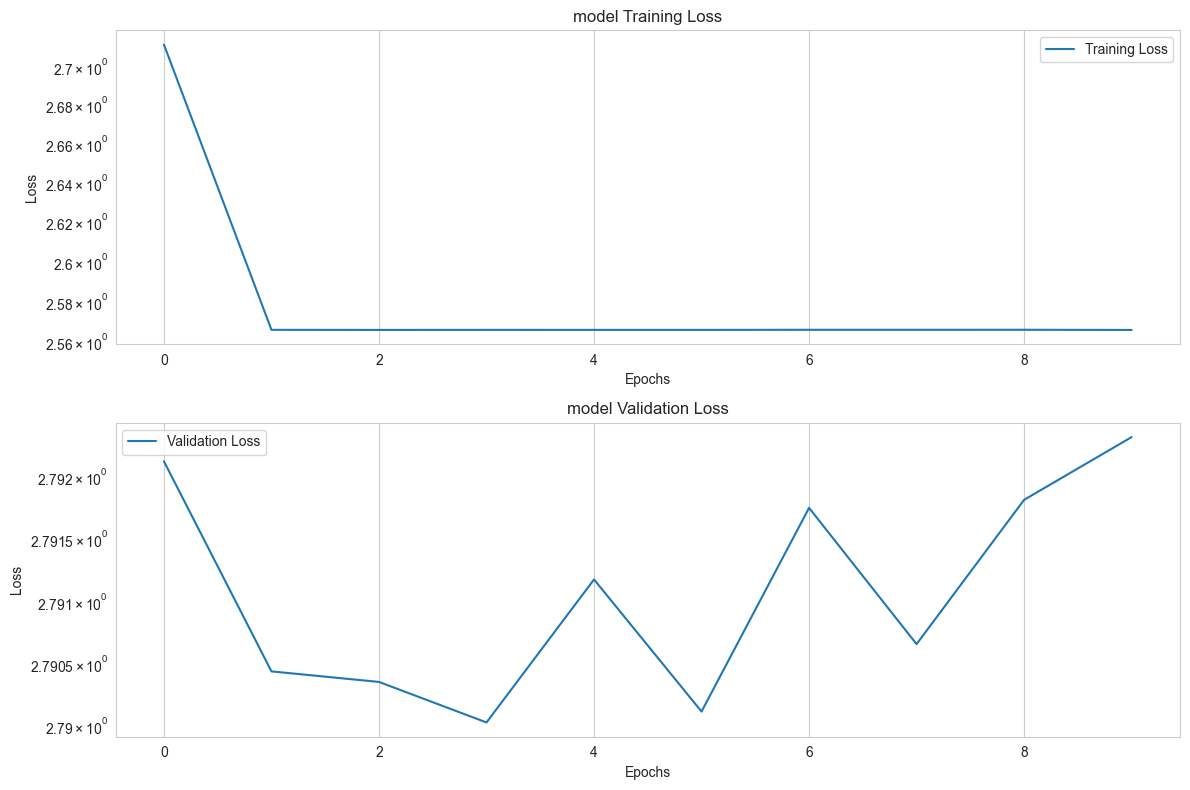

In [48]:
plot_loss(history, 'model')

In [49]:
y_pred = model.predict(static_test_combined)

70999/70999 [==============================] - 72s 1ms/step


In [50]:
mae = mean_absolute_error(y_test, y_pred)
mae

2.4917787221980627

In [51]:
abs_error = np.abs(y_test - y_pred.flatten())

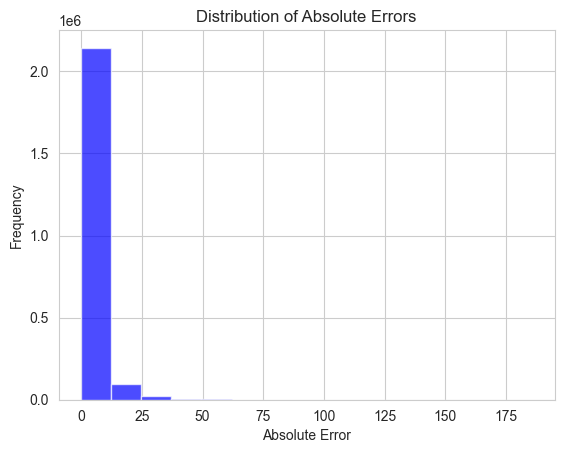

In [52]:
plt.hist(abs_error, bins=15, color='blue', alpha=0.7)
plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.show()

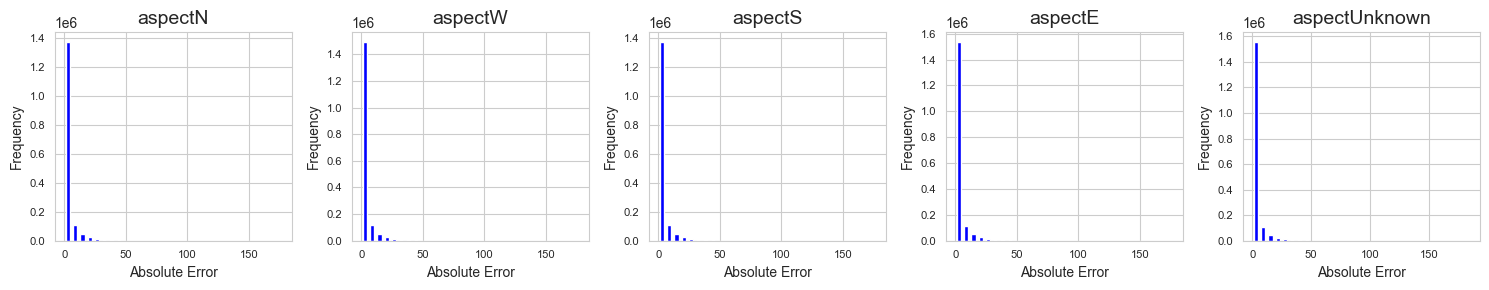

In [53]:
region_columns = ['aspectN', 'aspectW', 'aspectS', 'aspectE', 'aspectUnknown']

threshold = 0.1

fig, axes = plt.subplots(nrows=1, ncols=len(region_columns), figsize=(15, 3))
axes = axes.flatten()

for i, region in enumerate(region_columns):
    idx = static_test_combined[region] > threshold
    region_indices = static_test_combined[idx].index

    if idx.sum() == 0 or np.isnan(abs_error[region_indices]).all():
        axes[i].set_title(f"{region} - No Data", fontsize=14)
        continue

    axes[i].hist(abs_error[region_indices], bins=30, histtype="barstacked", color="blue", rwidth=0.6, edgecolor="white")
    axes[i].set_title(f"{region}", fontsize=14)
    axes[i].set_xlabel("Absolute Error", fontsize=10)
    axes[i].set_ylabel("Frequency", fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

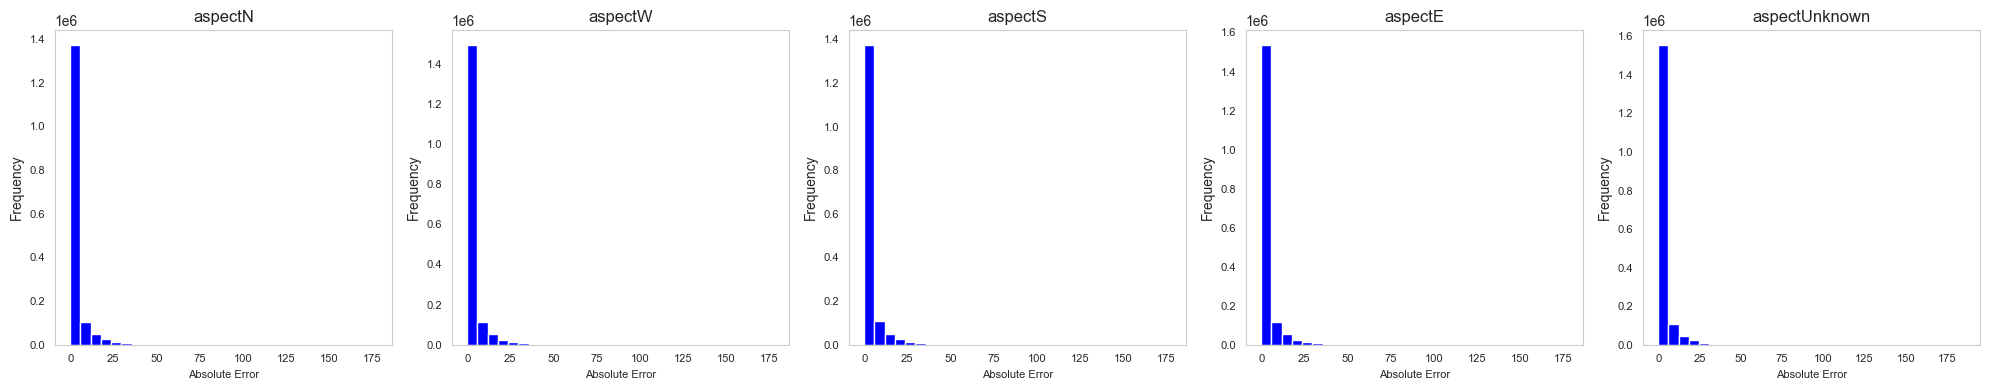

In [54]:
region_columns = ['aspectN', 'aspectW', 'aspectS', 'aspectE', 'aspectUnknown']

threshold = 0.1

fig, axes = plt.subplots(nrows=1, ncols=len(region_columns), figsize=(20, 4))
axes = axes.flatten()

for i, region in enumerate(region_columns):
    idx = static_test_combined[region] > threshold
    region_indices = static_test_combined[idx].index

    if idx.sum() == 0 or np.isnan(abs_error[region_indices]).all():
        axes[i].set_title(f"{region} - No Data", fontsize=14)
        axes[i].grid(False) 
        continue

    axes[i].hist(abs_error[region_indices], bins=30, histtype="barstacked", color="blue", edgecolor="white")
    axes[i].set_title(f"{region}", fontsize=12)
    axes[i].set_xlabel("Absolute Error", fontsize=8)
    axes[i].set_ylabel("Frequency", fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)
    axes[i].grid(False)  

plt.tight_layout()
plt.show()